In [1]:
# -*- coding: utf-8 -*-
### Required libraries ------------------------------------------
import numpy as np
import os
import pandas as pd
from pandas import Series

# column 다 보이기
pd.set_option('display.max_columns', None)
#(참고) warning 제거를 위한 코드
#np.seterr(divide='ignore', invalid='ignore')

### Visualization libraries -------------------------------------
import seaborn as sns
color = sns.color_palette()
#sns.set_style('darkgrid')    #ticks

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["figure.figsize"] = (7,6)  # 크기 (inch)
plt.rcParams['axes.grid'] = True        # 격자선 여부
plt.rcParams['lines.linewidth'] = 2     # 선의 두께
plt.rcParams['lines.color'] = 'red'     # 선의 색깔

### Etc. libraries ----------------------------------------------
from datetime import datetime    # To access datetime 
# To print multiple output in a cell --------------------------
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'last_expr'

### *************************************************************


In [2]:
#!pip install opencv-python
import cv2
import time

#!pip install vidgear
from vidgear.gears import WriteGear

# 4.5이상
print(cv2.__version__)

# !pip install --trusted-host pypi.python.org moviepy
# !pip install imageio-ffmpeg

4.5.2


* Tensorflow 에서 Pretrained 된 모델 파일을 OpenCV에서 로드하여
  이미지와 영상에 대한 Object Detection 수행.
* CPU기반 환경에서 SSD의 Inference 속도 주시. 

# 1. SSD+Mobilenet v3 기반 

# 1.1. Object Detection 수행 - Image

In [ ]:
!mkdir ./data

!wget -O ./data/rose.jpg \
         https://thumb.mt.co.kr/06/2020/10/2020101522424982247_3.jpg


image shape: (680, 680, 3)


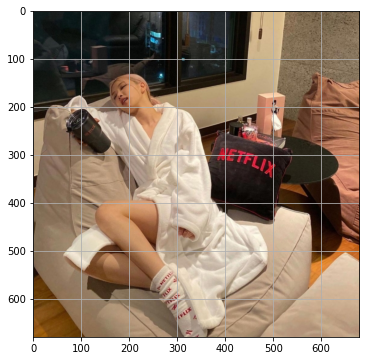

In [3]:
input_img_path='./data/rose.jpg'
img = cv2.imread(input_img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

print('image shape:', img.shape)
plt.figure(figsize=(6, 6))
plt.imshow(img_rgb)

# 1.2. Object Detection 수행  - Video

In [ ]:
# !pip install --trusted-host pypi.python.org moviepy
# !pip install imageio-ffmpeg

#!wget -O ./data/John_Wick_small1.mp4  \
#        https://github.com/chulminkw/DLCV/blob/master/data/video/John_Wick_small.mp4?raw=true

#!cp /workspace/data/hanwoo/Hanwoo_D10_20210606130000.mp4 ./data/Hanwoo_D10.mp4
#!cp /workspace/data/hanwoo/Hanwoo_D03_20210606125959.mp4 ./data/Hanwoo_D03.mp4

In [ ]:
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
ffmpeg_extract_subclip("./data/Hanwoo_D03.mp4", 300, 306, targetname="./data/Hanwoo_D03_cut.mp4")  #360


In [4]:
input_video_path = './data/Hanwoo_D03_cut.mp4'
#input_video_path = './data/John_Wick_small.mp4'
vcap = cv2.VideoCapture(input_video_path) # 0=camera
if vcap.isOpened(): 
    v_width  = vcap.get(cv2.CAP_PROP_FRAME_WIDTH)   # float `width`
    v_height = vcap.get(cv2.CAP_PROP_FRAME_HEIGHT)  # float `height`
    v_fps = vcap.get(cv2.CAP_PROP_FPS)
    v_fcnt= vcap.get(cv2.CAP_PROP_FRAME_COUNT)
print(v_width,v_height,v_fps,v_fcnt)

2944.0 1656.0 20.0 120.0


In [5]:
from IPython.display import Video
Video(input_video_path, width=v_width/4, height=v_height/4)

##  2) OpenCV에서 Inference모델 생성 (다운받은 모델파일과 환경파일을 활용)

### 모델파일과 환경파일 다운로드
다운로드 URL : https://github.com/opencv/opencv/wiki/TensorFlow-Object-Detection-API
 - Tensorflow에서 Pretrained 된 Inference모델(Frozen graph)
   pretrained 모델 (weight파일) 다운로드 후 , 압축해제
 - (pretrained 모델을 위한) 환경파일 다운로드 url
 
* https://github.com/opencv/opencv/pull/16760 <br />
* SSD + Mobilenet v3 backbone은 OpenCV dnn모듈이 아니라, <br />
dnn_detectinonModel()함수로 생성가능 => dnn_DetectionModel()은 dnn_Model 객체 반환
* 해당 SSD 모델은 image pixel값을 -1 ~ 1 사이로 정규화하고 image size는 320, 320으로 설정.

In [6]:
!mkdir ./pretrained
!wget -O ./pretrained/ssd_mobilenet_v3_large_coco_2020_01_14.tar.gz \
         http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v3_large_coco_2020_01_14.tar.gz
!!tar -xvf ./pretrained/ssd_mobilenet*.tar.gz -C ./pretrained 


!wget -O ./pretrained/ssd_config_02.pbtxt \
         https://gist.githubusercontent.com/dkurt/54a8e8b51beb3bd3f770b79e56927bd7/raw/2a20064a9d33b893dd95d2567da126d0ecd03e85/ssd_mobilenet_v3_large_coco_2020_01_14.pbtxt


mkdir: cannot create directory ‘./pretrained’: File exists
--2021-07-21 12:40:11--  http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v3_large_coco_2020_01_14.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 172.217.26.48, 2404:6800:4004:80d::2010
Connecting to download.tensorflow.org (download.tensorflow.org)|172.217.26.48|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49318766 (47M) [application/gzip]
Saving to: ‘./pretrained/ssd_mobilenet_v3_large_coco_2020_01_14.tar.gz’

./pretrained/ssd_mo 100%[===================>]  47.03M  65.1MB/s    in 0.7s    

2021-07-21 12:40:12 (65.1 MB/s) - ‘./pretrained/ssd_mobilenet_v3_large_coco_2020_01_14.tar.gz’ saved [49318766/49318766]

--2021-07-21 12:40:12--  https://gist.githubusercontent.com/dkurt/54a8e8b51beb3bd3f770b79e56927bd7/raw/2a20064a9d33b893dd95d2567da126d0ecd03e85/ssd_mobilenet_v3_large_coco_2020_01_14.pbtxt
Resolving gist.githubusercontent.com (gist.githubusercontent.c

In [ ]:
!pwd
!ls -lia ./pretrained/ssd_mobilenet_v3_large_coco_2020_01_14*

#### Model파일과 config파일을 인자로 하여 inference 모델을 DNN에서 로딩함. 
즉, DNN의 readNetFromTensorflow()로 tensorflow inference 모델을 로딩

In [7]:
# cv_net_m = cv2.dnn_DetectionModel(
#     './pretrained/ssd_mobilenet_v3_large_coco_2020_01_14/frozen_inference_graph.pb',
#     './pretrained/ssd_config_02.pbtxt'
# )
# # pre-processing
# cv_net_m.setInputSize(320, 320)
# cv_net_m.setInputScale(1.0 / 127.5)
# cv_net_m.setInputMean((127.5, 127.5, 127.5))
# cv_net_m.setInputSwapRB(True)

<dnn_Model 0x7f02b03701f0>

### 3-1) 이미지 preprocessing 수행후, Network에 입력

### dnn_Model 객체의 detect() 메소드는 입력 이미지를 받아서 특정 confidence threshold 이상의 모든 object inference 결과를 반환. 
* class id값, confidence score값, bbox 좌표값이 arrary로 반환됨.
* bbox 좌표값의 경우 0~1사이 값이 아니라 정수형의 위치값이 반환됨. 단 xmin, ymin, width, height 형태로 반환되므로 유의 필요. 

### 3-2) Object Detection 수행 후, 결과를 이미지에 시각화

#### coco데이터셋의 Classid별 ClassName 지정. 

In [8]:
labels_to_names = {1:'person',2:'bicycle',3:'car',4:'motorcycle',5:'airplane',6:'bus',7:'train',8:'truck',9:'boat',10:'traffic light',
                    11:'fire hydrant',12:'street sign',13:'stop sign',14:'parking meter',15:'bench',16:'bird',17:'cat',18:'dog',19:'horse',20:'sheep',
                    21:'cow',22:'elephant',23:'bear',24:'zebra',25:'giraffe',26:'hat',27:'backpack',28:'umbrella',29:'shoe',30:'eye glasses',
                    31:'handbag',32:'tie',33:'suitcase',34:'frisbee',35:'skis',36:'snowboard',37:'sports ball',38:'kite',39:'baseball bat',40:'baseball glove',
                    41:'skateboard',42:'surfboard',43:'tennis racket',44:'bottle',45:'plate',46:'wine glass',47:'cup',48:'fork',49:'knife',50:'spoon',
                    51:'bowl',52:'banana',53:'apple',54:'sandwich',55:'orange',56:'broccoli',57:'carrot',58:'hot dog',59:'pizza',60:'donut',
                    61:'cake',62:'chair',63:'couch',64:'potted plant',65:'bed',66:'mirror',67:'dining table',68:'window',69:'desk',70:'toilet',
                    71:'door',72:'tv',73:'laptop',74:'mouse',75:'remote',76:'keyboard',77:'cell phone',78:'microwave',79:'oven',80:'toaster',
                    81:'sink',82:'refrigerator',83:'blender',84:'book',85:'clock',86:'vase',87:'scissors',88:'teddy bear',89:'hair drier',90:'toothbrush',
                    91:'hair brush'}


## _**여러 이미지의 object detection. 함수사용**_

## 3) get_detected_img
### 3-1) 이미지 preprocessing 수행후, Network에 입력
### 3-2) Object Detection 수행 후, 결과를 이미지에 시각화

In [24]:
def get_detected_img_renew(cv_net, img_array, score_threshold, is_print=True):

    draw_img = img_array.copy()
    start = time.time()
    # 중요변화 포인트
    classes, confidences, boxes = cv_net.detect(img_array, confThreshold=0.5)
    
    color_green=(0, 255,   0)
    color_red=(0,   0, 255)
    # detected 된 object들을 iteration 하면서 정보 추출
    for class_id, confidence_score, box in zip(classes.flatten(), confidences.flatten(), boxes):
        if confidence_score > 0.5:
            caption = "{}: {:.4f}".format(labels_to_names[class_id], confidence_score)
            cv2.rectangle(draw_img, (box[0], box[1]), (box[0]+box[2], box[1]+box[3]), color=color_green, thickness=2)
            cv2.putText(draw_img, caption, (box[0], box[1]), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color_red, 2)
            #print(caption)#, class_id, box)
  
    if is_print:
        print('Detection 수행시간:',round(time.time() - start, 2),"초")

    return draw_img


person: 0.6285
person: 0.5688
remote: 0.5561
chair: 0.5422
couch: 0.5388
remote: 0.5253
Detection 수행시간: 0.1 초


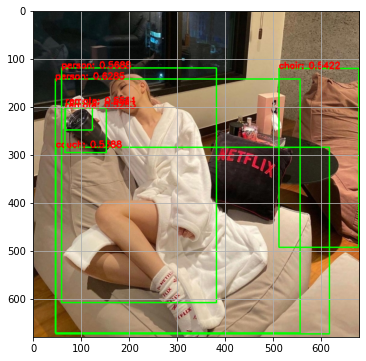

In [25]:
input_img_path='./data/rose.jpg'
img = cv2.imread(input_img_path)

my_img= get_detected_img_renew(
    cv_net_m, 
    img, 
    score_threshold=0.2, 
    is_print=True)
myimg = cv2.cvtColor(my_img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(6,6))
plt.imshow(myimg)

### 3-2) dnn_Model을 만드는 함수 생성.

In [26]:
def get_cv_detection_model(pretrained_path, config_path):
    cv_net = cv2.dnn_DetectionModel(pretrained_path, config_path)
    cv_net.setInputSize(320, 320)
    cv_net.setInputScale(1.0 / 127.5)
    cv_net.setInputMean((127.5, 127.5, 127.5))
    cv_net.setInputSwapRB(True)
  
    return cv_net

cv_net_m = get_cv_detection_model(
    './pretrained/ssd_mobilenet_v3_large_coco_2020_01_14/frozen_inference_graph.pb',
    './pretrained/ssd_config_02.pbtxt')

### 4) Video Detection용 전용 함수 생성 - Video Inferece 수행.

In [29]:
def do_detected_video_renew(cv_net, input_path, output_path, score_threshold, is_print):
    stream = cv2.VideoCapture(input_path)
    output_params= {"-vcodec":"libx264", "-crf": 0, "-preset": "fast"}
    vid_writer = WriteGear(output_path, logging=True, **output_params)
    
    frame_cnt = int(stream.get(cv2.CAP_PROP_FRAME_COUNT))
    print('총 Frame 갯수:', frame_cnt, )

    while True:
        (hasFrame, img_frame) = stream.read()
        if not hasFrame:
            print('End of the frame. done.'); break
        
        returned_frame = get_detected_img_renew(cv_net, img_frame, score_threshold, is_print=True)
        vid_writer.write(returned_frame)

    cv2.destroyAllWindows()
    stream.release()
    vid_writer.close()


## 5) 결과확인

In [30]:
#do_detected_video_renew(cv_net_m, './data/Jonh_Wick_small.mp4', './data/John_Wick_small_m3.mp4', 0.2, False)

#output_video_path = './data/Hanwoo_D03_cut_output.mp4'
output_video_path = './data/J_output.mp4'

do_detected_video_renew(
    cv_net=cv_net_m, 
    input_path =input_video_path, 
    output_path=output_video_path, 
    score_threshold=0.2, 
    is_print=False
)


13:06:52 :: WriteGear :: DEBUG :: Compression Mode is enabled therefore checking for valid FFmpeg executables.
13:06:52 :: WriteGear :: DEBUG :: Output Parameters: {'-vcodec': 'libx264', '-crf': 0, '-preset': 'fast'}
13:06:52 :: Helper :: DEBUG :: Final FFmpeg Path: ffmpeg
13:06:52 :: Helper :: DEBUG :: FFmpeg validity Test Passed!
13:06:52 :: Helper :: DEBUG :: Found valid FFmpeg Version: `b'3.4.8-0ubuntu0.2'` installed on this system
13:06:52 :: WriteGear :: DEBUG :: Found valid FFmpeg executables: `ffmpeg`.
13:06:52 :: WriteGear :: DEBUG :: Compression Mode is configured properly!


총 Frame 갯수: 120


13:06:53 :: WriteGear :: DEBUG :: InputFrame => Height:1656 Width:2944 Channels:3
13:06:53 :: WriteGear :: DEBUG :: Executing FFmpeg command: `ffmpeg -y -f rawvideo -vcodec rawvideo -s 2944x1656 -pix_fmt bgr24 -i - -vcodec libx264 -crf 0 -preset fast /workspace/git/DLCV/one/data/J_output.mp4`


cow: 0.5910
cow: 0.5715
cow: 0.5511
horse: 0.5439
horse: 0.5316
cow: 0.5271
cow: 0.5206
Detection 수행시간: 0.17 초
cow: 0.5962
cow: 0.5665
cow: 0.5601
horse: 0.5540
cow: 0.5212
cow: 0.5103
Detection 수행시간: 0.12 초
cow: 0.6044
cow: 0.5634
cow: 0.5546
horse: 0.5513
cow: 0.5415
horse: 0.5151
cow: 0.5048
Detection 수행시간: 0.1 초
cow: 0.6067
cow: 0.5668
cow: 0.5598
cow: 0.5566
horse: 0.5506
horse: 0.5109
cow: 0.5098
cow: 0.5036
Detection 수행시간: 0.11 초
cow: 0.6114
cow: 0.5638
cow: 0.5597
cow: 0.5563
horse: 0.5485
Detection 수행시간: 0.1 초
cow: 0.5827
cow: 0.5620
cow: 0.5571
cow: 0.5544
horse: 0.5422
cow: 0.5090
cow: 0.5046
Detection 수행시간: 0.11 초
cow: 0.5935
cow: 0.5804
cow: 0.5766
cow: 0.5481
cow: 0.5215
cow: 0.5139
cow: 0.5087
horse: 0.5035
cow: 0.5019
Detection 수행시간: 0.1 초
cow: 0.6142
cow: 0.5817
cow: 0.5806
cow: 0.5499
horse: 0.5228
cow: 0.5109
cow: 0.5004
Detection 수행시간: 0.1 초
cow: 0.6180
cow: 0.5920
cow: 0.5682
cow: 0.5622
cow: 0.5397
cow: 0.5178
cow: 0.5025
cow: 0.5021
Detection 수행시간: 0.11 초
cow: 0.

13:07:09 :: WriteGear :: DEBUG :: Terminating WriteGear Processes.


cow: 0.6822
cow: 0.6093
cow: 0.5828
cow: 0.5825
cow: 0.5499
cow: 0.5324
cow: 0.5284
cow: 0.5243
person: 0.5229
cow: 0.5124
Detection 수행시간: 0.1 초
cow: 0.7029
cow: 0.5980
cow: 0.5932
cow: 0.5846
cow: 0.5654
cow: 0.5411
cow: 0.5355
cow: 0.5236
person: 0.5140
cow: 0.5025
horse: 0.5010
Detection 수행시간: 0.1 초
End of the frame. done.


In [31]:
from IPython.display import Video
Video(output_video_path, width=v_width/4, height=v_height/4)